# Plots for differentiation and thermal evolution<a class="anchor" id="top"></a>
For the whole thermal evolution:
+ [temperature](#temp)
+ [% silicate melted](#silicate)
+ [Rayleigh number](#critical-rayleigh)


For differentiation stage:
+ [% iron melted](#iron)

For the thermal evolution stage:
+ [temperatures and heat fluxes](#temp-heat)
+ [inner core size and magnetic Reynolds number](#Rem)

## Set-up

In [1]:
#import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


#scale time to Myr
from parameters import Myr, Tms, Tml, Xs_0 #need to change so import from save file instead

Choose run and whether you want to save figure

In [21]:
run=13
save = False # do you want to save your figures?
conduction = True #does the mantle switch to conduction

Load npz files for differentiation

In [3]:
npzfile = np.load(f'Results_combined/run_{run}_diff.npz')
Tdiff = npzfile['Tdiff'] 
iron = npzfile['Xfe']
silicate_d = npzfile['Xsi']
tdiff = npzfile['t_diff']
Ra_d = npzfile['Ra']
Ra_crit_d = npzfile['Ra_crit']

Load npz files for thermal evolution

In [22]:
npzfile = np.load('Results_combined/run_{}.npz'.format(run))
Tc= npzfile['Tc'] 
Tc_conv = npzfile['Tc_conv']
Tcmb = npzfile['Tcmb']
Tm_mid = npzfile['Tm_mid']
Tm_conv = npzfile['Tm_conv']
Tm_surf = npzfile['Tm_surf'] 
T_profile = npzfile['T_profile']
f = npzfile['f'] 

t = npzfile['t'] #time in s
Rem1 = npzfile['Rem1'] # magnetic Reynolds number from compositional (Nimmo) and thermal convection (whatever is larger at each time step)
Rem2 = npzfile['Rem2'] # magnetic Reynolds number from compositional (Nichols) and thermal convection (whatever is larger at each time step)
Flux = npzfile['Flux']
Ra = npzfile['Ra'] 
RaH = npzfile['RaH'] 
RanoH = npzfile['RanoH'] 
Racrit = npzfile['Racrit'] 
d0 = npzfile['d0'] 
min_unstable = npzfile['min_unstable'] 
Xs = npzfile['Xs']
dl = npzfile['dl']
dx = npzfile['dc']
Fs = Flux[0]
Fcmb = Flux[1]
Fad = Flux[2]
Frad = Flux[3]

Run Info

In [23]:
run_info = pd.read_csv('run_info4.csv',delimiter=',')

row = run_info[run_info['run']==run]
#use -1 so always read most recently written row tih that run number
r = row.iloc[-1,1] #radius [m]
Tm0 = row.iloc[-1,2] # initial mantle and core temp [K]
tstart = row.iloc[-1,3]
tend = row.iloc[-1,4] # max possible time of simulation [Myr]
tstep = row.iloc[-1,5] #max timestep [Myr]
tsolid = row.iloc[-1,6] #time at which solidifcation finishes [Myr] if tsolid == tend then core may not have finished solidifying
cond_t= row.iloc[-1,7] #time at which mantle started conducting
if conduction == True:
    cond_t = cond_t/Myr #time at which mantle switched to conduction
    
dr=row.iloc[-1,9] #cell spacing
dt =row.iloc[-1,10] #T_profile output frequency
viscosity = row.iloc[-1,11] #viscosity profile

Calculate silicate melt content for thermal evolution

In [6]:
nmantle = int((r/dr)/2)
silicate_t = (T_profile[:,nmantle:] - Tms)/(Tml-Tms)

Concatenate shared variables

In [7]:
Tall = np.hstack((Tdiff,np.transpose(T_profile)))
tall = np.append(tdiff,t)
iron_all = np.hstack
Ra_all = np.append(Ra_d,Ra)
Ra_crit_all = np.append(Ra_crit_d,Racrit)

Scale time, choose whether or not to plot logarithmically

In [8]:
t_plot_all = tall/Myr
t_plot_t = t/Myr
log_time = True # do you want to plot time logarithmically
#dt = 1 #for now plot everything in units of timestep

Comparison with Kathryn Case 1

In [9]:
diff_time = tdiff[-1]/Myr
diff_T = Tdiff[int(nmantle),-1]
peakT = np.amax(Tall[nmantle:,:])
loc_max = np.where(Tall[nmantle:,:]==peakT)[1][0] #take the set of time coordinates and first value (they should all be the same)
tmax = tall[loc_max]/Myr
if np.all(T_profile[:,int(nmantle)-2]<Tcmb):
    tstrat_end = np.inf
else:
    tstrat_end = t[Tcmb < T_profile[:,int(nmantle)-2]][0]/Myr
    
if np.any(min_unstable==0):
     terode = t[np.where(min_unstable==0)[0]][0]/Myr
else:
    terode = np.inf
if np.all(Fcmb < Fad):
    tc_conv = np.inf
else:
    tc_conv1 = t[np.where(Fcmb>Fad)[0]][0]/Myr
    tc_conv2 = t[np.where(Fcmb>Fad)[0]][-1]/Myr
print(tc_conv1,tc_conv2)

8.717134386098428 27.211062753678338


In [10]:
print(f'Differentiation is at {diff_time:.2f} Myr')
print(f'The temperature at differentiation is at {diff_T:.2f}K')
print(f'Peak magma ocean temp is {peakT:.0f}K at {tmax:.2f} Myr')
print(f'Mantle hotter than the core until {tstrat_end:.2f} Myr')
print(f'Erosion of stratification by {terode:.2f} Myr') 
print(f'Super adiabatic CMB heat flux at {tc_conv1:.2f} Myr')
print(f'Super adiabatic CMB heat flux ends at {tc_conv2:.2f} Myr')

Differentiation is at 1.22 Myr
The temperature at differentiation is at 1503.30K
Peak magma ocean temp is 1629K at 1.72 Myr
Mantle hotter than the core until 8.72 Myr
Erosion of stratification by 25.71 Myr
Super adiabatic CMB heat flux at 8.72 Myr
Super adiabatic CMB heat flux ends at 27.21 Myr


## Temperature <a class="anchor" id="temp"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

In [11]:
import matplotlib.colors as mcolors

In [12]:
rplot = np.arange(0,r,dr)/1e3

In [13]:
r_unstable=np.array([]) 
for ind in min_unstable:
    r_unstable = np.append(r_unstable,rplot[int(ind)])
rc = r/2

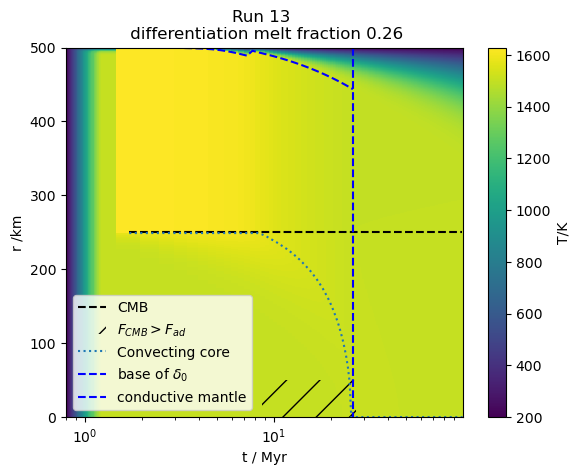

In [32]:
plt.figure()
plt.pcolormesh(t_plot_all,rplot,Tall,shading = 'nearest') # use same vmin and vmax as other plots to make them comparable
plt.hlines(rc/1e3,min(t/Myr),max(tall/Myr),linestyle='--',color='black',label='CMB')
plt.fill_betweenx([0,rc/5e3],t[np.where(Fcmb>Fad)[0]][0]/Myr,t[np.where(Fcmb>Fad)[0]][-1]/Myr,alpha=0,hatch='/',label='$F_{CMB}>F_{ad}$')
plt.plot(t/Myr,r_unstable,linestyle='dotted',label='Convecting core')
if conduction == True:
    plt.plot(t[t/Myr<=cond_t]/Myr,(r-d0[t/Myr<=cond_t])/1e3,linestyle='dashed',label='base of $\delta_0$',color='blue')
    plt.vlines(t[t/Myr<=cond_t][-1]/Myr,r/1e3,0,linestyle='dashed',label='conductive mantle',color='blue')
else:
    plt.plot(t/Myr,(r-d0)/1e3,linestyle='dashed',label='base of $\delta_0$',color='blue')
plt.ylabel('r /km')
plt.xlabel('t / Myr')
plt.ylim([0,r/1e3])
plt.colorbar(label='T/K')
plt.title(f'Run {run} \n differentiation melt fraction {(diff_T-1400)/400:.2f}')
plt.xscale('log')
plt.legend(loc='lower left')
if save == True:
    plt.savefig(f'Plots/Tall_run{run}.png')

## Melted silicate content <a class="anchor" id="silicate"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

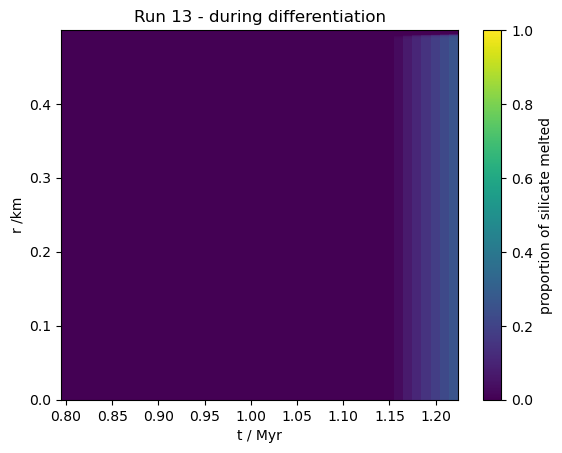

In [15]:
plt.figure()
plt.pcolormesh(tdiff/Myr, rplot/1e3,silicate_d,shading = 'nearest',vmin=0,vmax=1) # use same vmin and vmax as other plots to make them comparable
#plt.yscale('log')
plt.ylabel('r /km')
plt.xlabel('t / Myr')
#plt.ylim([0,400])
plt.title(f'Run {run} - during differentiation')
plt.colorbar(label='proportion of silicate melted')
if save ==True:
    plt.savefig(f'Plots/si_diff_run_{run}.png')

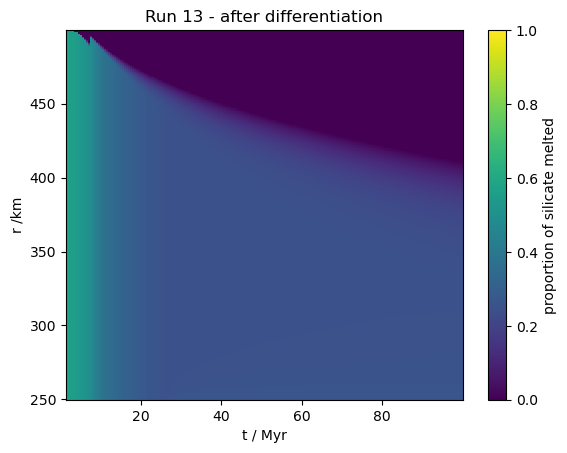

In [16]:
rmantle = np.arange(r/2,r,dr)/1e3
plt.figure()
plt.pcolormesh(t/Myr, rmantle,np.transpose(silicate_t),shading = 'nearest',vmin=0, vmax=1) # use same vmin and vmax as other plots to make them comparable
#plt.yscale('log')
plt.ylabel('r /km')
plt.xlabel('t / Myr')
#plt.ylim([0,400])
plt.title(f'Run {run} - after differentiation')
plt.colorbar(label='proportion of silicate melted')
if save ==True:
    plt.savefig(f'Plots/si_diff_run_{run}.png')

## Rayleigh number<a class="anchor" id="critical-rayleigh"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

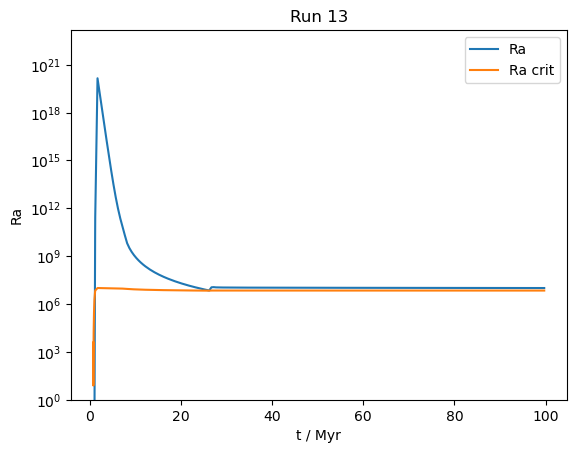

In [17]:
plt.figure()
plt.semilogy(t_plot_all,Ra_all,label='Ra')
plt.semilogy(t_plot_all,Ra_crit_all,label='Ra crit') #
plt.ylim(bottom=1e0)
#plt.xlim([0,5])
plt.ylabel('Ra')
plt.xlabel('t / Myr')
plt.title(f'Run {run}')
plt.legend()
if save == True:
    plt.savefig(f'Plots/Racrit_diff_run{run}b.png')

## Melted iron content during differentiation<a class="anchor" id="iron"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

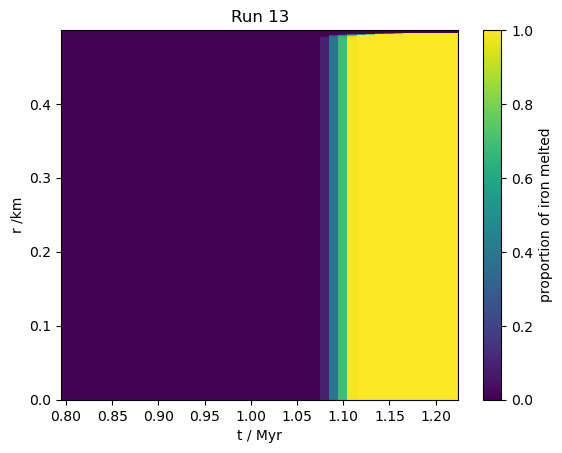

In [18]:
plt.figure()
plt.pcolormesh(tdiff/Myr, rplot/1e3,iron,shading = 'nearest') # use same vmin and vmax as other plots to make them comparable
#plt.yscale('log')
plt.ylabel('r /km')
plt.xlabel('t / Myr')
#plt.ylim([0,400])
plt.title(f'Run {run}')
plt.colorbar(label='proportion of iron melted')
if save ==True:
    plt.savefig(f'Plots/fe_diff_run_{run}.png')

## Temperature and Flux Plot <a class="anchor" id="temp-heat"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

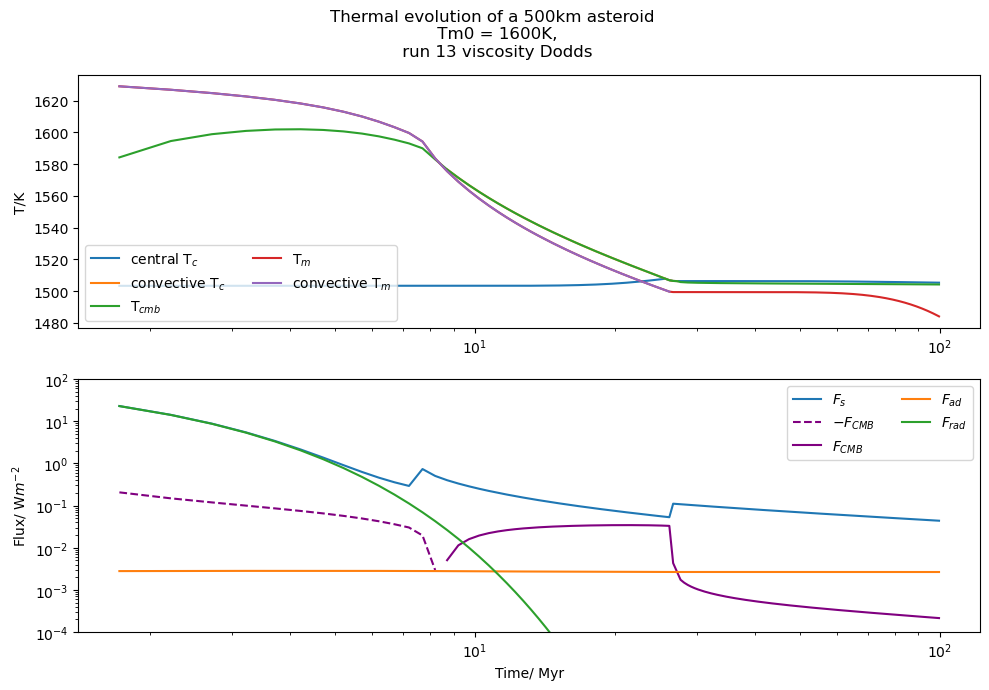

In [19]:
plt.figure(tight_layout=True,figsize=[10,7])
plt.suptitle(f'Thermal evolution of a {r/1e3:.0f}km asteroid \n Tm0 = {Tm0}K,\n run {run} viscosity {viscosity}')

xmin=tstart

#temperatures as function of time
plt.subplot(2,1,1)
if log_time == True:
    plt.semilogx(t_plot_t,Tc,label='central T$_c$')
    plt.semilogx(t_plot_t[Tc_conv!=0],Tc_conv[Tc_conv!=0],label='convective T$_c$')
    plt.semilogx(t_plot_t,Tcmb,label='T$_{cmb}$')
    plt.semilogx(t_plot_t,Tm_mid,label='T$_m$')
    plt.semilogx(t_plot_t[Tm_conv!=0],Tm_conv[Tm_conv!=0],label='convective T$_m$')
    #plt.semilogx(t_plot_t,Tm_conv,label='convective T$_m$')
    #plt.semilogx(t_plot_t,Tm_surf,label='T$_m$ - surface')
else:
    plt.plot(t_plot_t,Tc,label='central T$_c$')
    plt.plot(t_plot_t[Tc_conv!=0],Tc_conv[Tc_conv!=0],label='convective T$_c$')
    plt.plot(t_plot_t,Tcmb,label='T$_{cmb}$')
    plt.plot(t_plot_t,Tm_mid,label='T$_m$')
    plt.plot(t_plot_t[Tm_conv!=0],Tm_conv[Tm_conv!=0],label='convective T$_m$')
    #plt.plot(t_plot_t,Tm_surf,label='T$_m$ - surface')
if conduction == True:
    plt.vlines(cond_t,ymin=min(Tm_surf),ymax=1600,color='black',linestyle='--',label='conduction')
#plt.ylim([1460,1650]) #use these limits when comparing runs
plt.ylabel('T/K')
plt.legend(loc='lower left', ncol= 2)

#fluxes as function of time
plt.subplot(2,1,2)

Fcmb_neg = Fcmb[Fcmb<0]
Fcmb_pos = Fcmb[Fcmb>0]
if log_time == True:
    plt.loglog(t_plot_t,Fs,label='$F_s$')
    plt.loglog(t_plot_t[Fcmb<0],abs(Fcmb_neg),label='$-F_{CMB}$',linestyle='dashed',color='purple')
    plt.loglog(t_plot_t[Fcmb>0],Fcmb_pos,label='$F_{CMB}$',color='purple')
    plt.loglog(t_plot_t,Fad,label='$F_{ad}$')
    plt.loglog(t_plot_t,Frad,label='$F_{rad}$')
else:
    plt.semilogy(t_plot_t,Fs,label='$F_s$')
    plt.semilogy(t_plot_t[Fcmb<0],abs(Fcmb_neg),label='$-F_{CMB}$',linestyle='dashed',color='purple')
    plt.semilogy(t_plot_t[Fcmb>0],Fcmb_pos,label='$F_{CMB}$',color='purple')
    plt.semilogy(t_plot_t,Fad,label='$F_{ad}$')
    plt.semilogy(t_plot_t,Frad,label='$F_{rad}$')
plt.xlabel('Time/ Myr')

plt.ylim([1e-4,1e2])   #use these limits when comparing runs
plt.ylabel('Flux/ W$m^{-2}$')
plt.legend(loc='upper right',ncol=2)


if save == True:
    plt.savefig('Plots/run_{}_Tflux.png'.format(run),dpi=450)


## Magnetic Reynolds number and inner core size <a class="anchor" id="Rem"></a>
<p align="right">(<a href="#top">back to top</a>)</p>

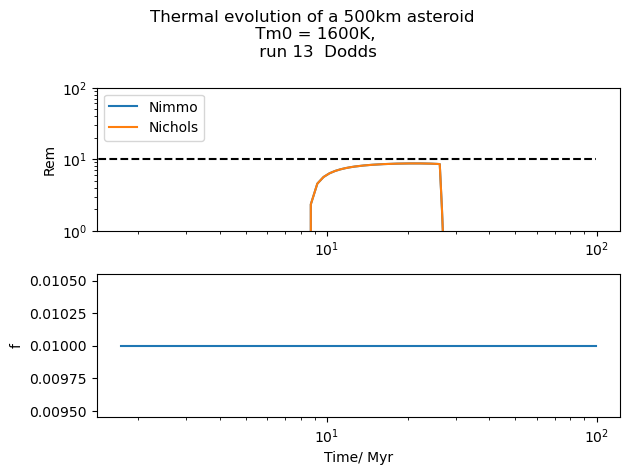

In [20]:
plt.figure(tight_layout=True)
plt.suptitle(f'Thermal evolution of a {r/1e3:.0f}km asteroid \n Tm0 = {Tm0}K, \n run {run}  {viscosity}')
plt.subplot(2,1,1)
plt.loglog(t_plot_t,Rem1,label='Nimmo')
plt.loglog(t_plot_t,Rem2,label='Nichols')
plt.hlines(10,xmin=0,xmax=t_plot_t[len(Rem1)-1],color='k',linestyle='--')
#plt.xlabel('Time/Myr')
plt.ylabel('Rem')
plt.legend(loc='upper left')
plt.ylim([1,100])

plt.subplot(2,1,2)
plt.semilogx(t_plot_t,f,label='f')
plt.xlabel('Time/ Myr')
plt.ylabel('f')

if save == True:
    plt.savefig('Plots/run_{}_Remf.png'.format(run),dpi=450)